In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import os
import pickle
import matplotlib.pyplot as plt


In [2]:
def load_csv(path):
    save_path = os.path.join(os.getcwd(), path)
    open_file = open(save_path, 'rb')
    labels_df = pickle.load(open_file)
    open_file.close()
    return labels_df


In [171]:
df = pd.read_csv('exported.predictions.Kahle2020.csv')
groups = load_csv(f"groups_and_oxi_states_5_frames/df_features_step_0.pkl")
df = df.merge(groups, left_on=['src_id'], right_on=['stru_id'])
df = df.drop(['starting_structure', 'src_database', 'src_id', 'diffusion_mean_cm2_s'], axis = 1)
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)
data = pd.read_csv('fv.v2.Kahle2020.csv')
data = data[data['temperature'] == 1000]
df = df.merge(data, left_on=['stru_id'], right_on=['src_id'])
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)
df = df.drop([
        'group',
        'stru_label',
        'stru_id',
        'temperature',
        'diffusion_std_cm2_s',
        'diffusion_sem_cm2_s',
        'label',
        'first_frame_structure',
        'starting_structure',
        'diffusion_mean_cm2_s',
        'src_database',
        'fv_1p0_WARNlowPES',
        'fv_2p0_WARNlowPES',
        'fv_3p0_WARNlowPES',
        'fv_4p0_WARNlowPES',
        'src_id',], axis = 1)
X, y = (df.drop(['is_good'], axis=1).to_numpy(), df['is_good'].astype(int).to_numpy())

In [112]:
preds = np.loadtxt('binaryclassification_results/preds.txt', dtype=float, delimiter=' ')

In [113]:
df = pd.read_csv('exported.predictions.Kahle2020.csv')
groups = load_csv(f"groups_and_oxi_states_5_frames/df_features_step_0.pkl")
df = df.merge(groups, left_on=['src_id'], right_on=['stru_id'])
df = df.drop(['starting_structure', 'src_database', 'src_id', 'diffusion_mean_cm2_s'], axis = 1)
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)
data = pd.read_csv('fv.v2.Kahle2020.csv')
data = data[data['temperature'] == 1000]
df = df.merge(data, left_on=['stru_id'], right_on=['src_id'])
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)

In [114]:
df_1 = df.copy()

In [115]:
df['new_labels'] = 0
df.loc[(df['group'] == 'group_A') | (df['stru_id'].isin([1008693, 39761, 421083]) == True), 'new_labels'] = 1


In [116]:
print(roc_auc_score(y, preds[:, 1]))

0.8385093167701864


In [117]:
y = df['new_labels'].to_list()
print(sum(y))
preds[y == 1]

9


array([], shape=(0, 116, 2), dtype=float64)

In [118]:
print(roc_auc_score(df['new_labels'].to_list(), preds[:, 1]))

0.8110072689511941


In [119]:
colors = []

In [120]:
df.loc[(df['group'] == 'group_A'), 'multigroup'] = 'group A'
df.loc[(df['stru_id'].isin([1008693, 39761, 421083]) == True), 'multigroup'] = 'three from group B'
df.loc[(df['group'] == 'group_B') & (df['stru_id'].isin([1008693, 39761, 421083]) == False), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_E'), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_C'), 'multigroup'] = 'bad_conductors'

df['preds'] = preds[:, 1]

df['diffusion_coef'] = df['diffusion_mean_cm2_s']
df.loc[df['diffusion_mean_cm2_s'] <= 1e-15, 'diffusion_coef'] = 1e-15

In [121]:
df_1 = df.copy()

In [122]:
print(roc_auc_score(y, preds[:, 1]))

0.8110072689511941


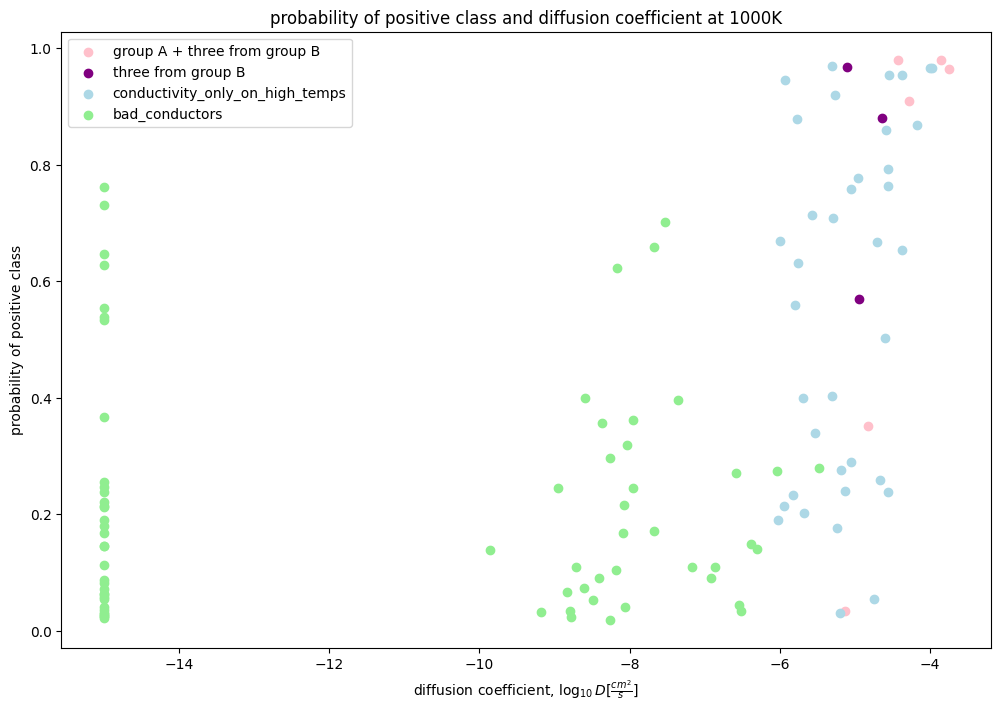

In [123]:
plt.figure(figsize=(12, 8))

first_group = df[df['multigroup'] == 'group A']
second_group = df[df['multigroup'] == 'three from group B']
third_group = df[df['multigroup'] == 'conductivity_only_on_high_temps']
fourth_group = df[df['multigroup'] == 'bad_conductors']

plt.scatter(np.log10(first_group['diffusion_coef']), first_group['preds'].to_list(), label='group A + three from group B', c = 'pink')
plt.scatter(np.log10(second_group['diffusion_coef']), second_group['preds'].to_list(), label='three from group B', c = 'purple')
plt.scatter(np.log10(third_group['diffusion_coef']).to_list(), third_group['preds'].to_list(), label='conductivity_only_on_high_temps', c = 'lightblue')
plt.scatter(np.log10(fourth_group['diffusion_coef']).to_list(), fourth_group['preds'].to_list(), label='bad_conductors', c = 'lightgreen')

plt.xlabel('diffusion coefficient, $\log_{10}D[\\frac{cm^2}{s}]$')
plt.ylabel('probability of positive class')

plt.title('probability of positive class and diffusion coefficient at 1000K')

plt.legend();

In [124]:
data = pd.read_csv('fv.v2.Kahle2020.csv')

In [125]:
df['relevance'] = -1
df.sort_values(by='diffusion_mean_cm2_s', ascending=False, inplace = True)
len_A = len(df[df['group'] == 'group_A'])
len_B = len(df[df['group'] == 'group_B'])
len_C = len(df[df['group'] == 'group_C'])
len_E = len(df[df['group'] == 'group_E'])
df.loc[df['group'] == 'group_A', 'relevance'] = np.arange(len_A)
df.loc[df['group'] == 'group_B', 'relevance'] = len_A + np.arange(len_B)
df.loc[df['group'] == 'group_E', 'relevance'] = len_A+len_B + np.arange(len_E)
df.loc[df['group'] == 'group_C', 'relevance'] = len_A+len_B+len_E + np.arange(len_C)
df['relevance'] = df.shape[0] - df['relevance']

In [126]:
df = pd.read_csv('exported.predictions.Kahle2020.csv')
groups = load_csv(f"groups_and_oxi_states_5_frames/df_features_step_0.pkl")
df = df.merge(groups, left_on=['src_id'], right_on=['stru_id'])
df = df.drop(['starting_structure', 'src_database', 'src_id', 'diffusion_mean_cm2_s'], axis = 1)
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)
data = pd.read_csv('fv.v2.Kahle2020.csv')
data.sort_values(by='temperature', ascending=False, inplace = True)
data.drop_duplicates(subset=['src_id', 'label'], keep='last', inplace=True, ignore_index=False)
df = df.merge(data, left_on=['stru_id'], right_on=['src_id'])
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)

In [3]:
data = pd.read_csv('fv.v2.Kahle2020.csv')
data.sort_values(by='temperature', ascending=False, inplace = True)

In [4]:
data

,starting_structure,temperature,diffusion_mean_cm2_s,diffusion_std_cm2_s,diffusion_sem_cm2_s,label,src_database,src_id,first_frame_structure,fv_0.100,...,fv_0.600,fv_0.700,fv_0.800,fv_0.900,fv_1.000,fv_1.100,fv_1.200,fv_1.300,fv_1.400,fv_1.500
0,"{""@module"": ""pymatgen.core.structure"", ""@class...",1000.0,1.473662e-09,6.356495e-09,3.669924e-09,Li24Al8N16,Crystallography Open Database,1537475,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000279,...,0.003411,0.004289,0.005167,0.006164,0.007222,0.008319,0.009436,0.010693,0.011850,0.013167
85,"{""@module"": ""pymatgen.core.structure"", ""@class...",1000.0,1.004951e-06,2.507733e-06,7.239201e-07,Li4B4S8O32,Icsd,425174,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000085,...,0.002071,0.003001,0.004424,0.006141,0.008607,0.011767,0.015752,0.020127,0.024987,0.030591
140,"{""@module"": ""pymatgen.core.structure"", ""@class...",1000.0,2.954715e-08,3.666310e-08,1.385735e-08,Li12P12O36,Crystallography Open Database,9014879,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000259,...,0.002987,0.003886,0.005119,0.006276,0.007645,0.009068,0.010731,0.013131,0.021895,0.023810
141,"{""@module"": ""pymatgen.core.structure"", ""@class...",1000.0,5.535165e-09,2.949475e-08,1.042797e-08,Li16Be10B12O36,Crystallography Open Database,4337787,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000256,...,0.002849,0.003667,0.004605,0.005554,0.006444,0.007566,0.008748,0.010070,0.011314,0.012594
143,"{""@module"": ""pymatgen.core.structure"", ""@class...",1000.0,1.509738e-06,1.725461e-06,3.260815e-07,Li12Si4O14,Crystallography Open Database,1539516,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000485,...,0.004826,0.006027,0.007435,0.008775,0.010299,0.011407,0.013024,0.014501,0.016256,0.018173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,"{""@module"": ""pymatgen.core.structure"", ""@class...",500.0,2.872166e-07,3.889073e-07,6.227500e-08,Li20B4S16O64,Icsd,428002,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000195,...,0.003838,0.005334,0.007345,0.009634,0.012387,0.015764,0.019569,0.023555,0.027800,0.032041
79,"{""@module"": ""pymatgen.core.structure"", ""@class...",500.0,8.901472e-10,1.877725e-08,6.638761e-09,Li18Ga6F36,Crystallography Open Database,8101456,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000304,...,0.003884,0.005026,0.006177,0.007536,0.008923,0.010565,0.012309,0.014187,0.016287,0.018435
77,"{""@module"": ""pymatgen.core.structure"", ""@class...",500.0,6.342740e-06,5.218028e-06,7.693562e-07,Li20Ge2P4S24,NaN,-1,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.001652,...,0.033566,0.042084,0.049282,0.073633,0.090393,0.113731,0.123220,0.125875,0.130491,0.132310
168,"{""@module"": ""pymatgen.core.structure"", ""@class...",500.0,1.397877e-06,3.964003e-06,1.099417e-06,Li4Ti4P4O20,Icsd,39761,"{""@module"": ""pymatgen.core.structure"", ""@class...",0.000190,...,0.003915,0.004908,0.006070,0.007269,0.008798,0.010469,0.012379,0.014421,0.016555,0.018820


In [ ]:
data = pd.read_csv('fv.v2.Kahle2020.csv')
data.sort_values(by='temperature', ascending=False, inplace = True)
data.drop_duplicates(subset=['src_id', 'label'], keep='last', inplace=True, ignore_index=False)

In [127]:
df['relevance'] = -1
df.sort_values(by='diffusion_mean_cm2_s', ascending=False, inplace = True)
len_A = len(df[df['group'] == 'group_A'])
len_B = len(df[df['group'] == 'group_B'])
len_C = len(df[df['group'] == 'group_C'])
len_E = len(df[df['group'] == 'group_E'])
df.loc[df['group'] == 'group_A', 'relevance'] = np.arange(len_A)
df.loc[df['group'] == 'group_B', 'relevance'] = len_A + np.arange(len_B)
df.loc[df['group'] == 'group_E', 'relevance'] = len_A+len_B + np.arange(len_E)
df.loc[df['group'] == 'group_C', 'relevance'] = len_A+len_B+len_E + np.arange(len_C)
df['relevance'] = df.shape[0] - df['relevance']

In [128]:
df.loc[(df['group'] == 'group_A'), 'multigroup'] = 'group A'
df.loc[(df['stru_id'].isin([1008693, 39761, 421083]) == True), 'multigroup'] = 'three from group B'
df.loc[(df['group'] == 'group_B') & (df['stru_id'].isin([1008693, 39761, 421083]) == False), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_E'), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_C'), 'multigroup'] = 'bad_conductors'

In [129]:
df.sort_index(inplace=True)
df['preds'] = preds[:, 1]

In [130]:
print(roc_auc_score(df['is_good'].astype(int).to_numpy(), preds[:, 1]))

0.8385093167701864


In [131]:
from scoring import bootstrap_roc_auc


In [132]:
estimated_mean, estimated_std = bootstrap_roc_auc(1000, df['is_good'].astype(int).to_numpy(), preds[:, 1])
print(estimated_mean, estimated_std)

0.8371950336118626 0.0405833403800891


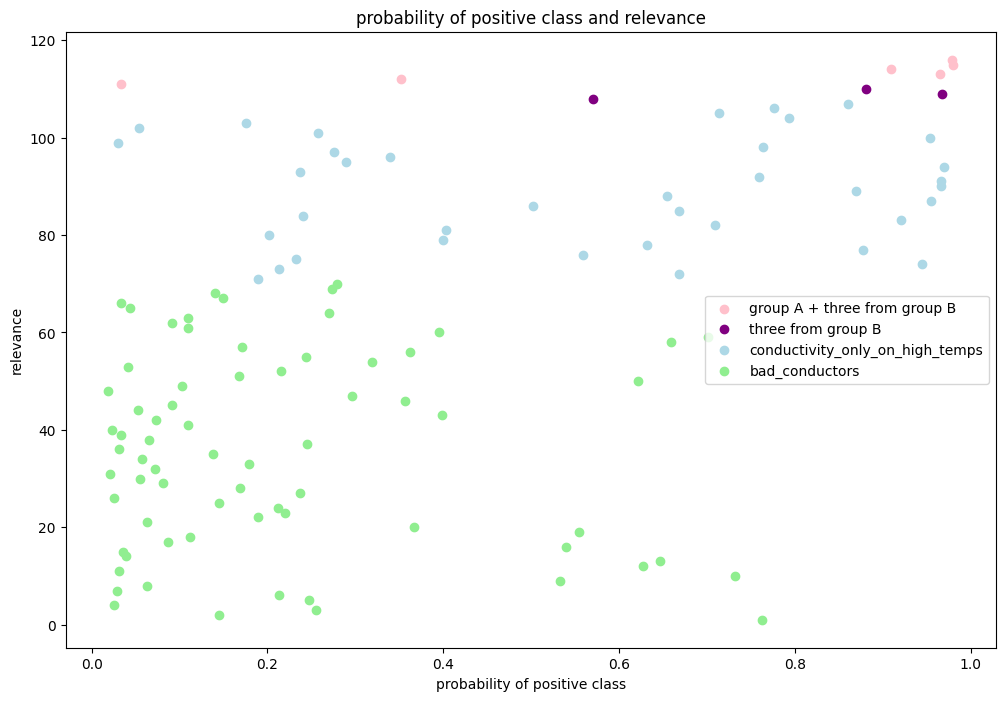

In [133]:
plt.figure(figsize=(12, 8))

first_group = df[df['multigroup'] == 'group A']
second_group = df[df['multigroup'] == 'three from group B']
third_group = df[df['multigroup'] == 'conductivity_only_on_high_temps']
fourth_group = df[df['multigroup'] == 'bad_conductors']

plt.scatter(first_group['preds'].to_list(), first_group['relevance'].to_list(), label='group A + three from group B', c = 'pink')
plt.scatter(second_group['preds'].to_list(), second_group['relevance'].to_list(), label='three from group B', c = 'purple')
plt.scatter(third_group['preds'].to_list(), third_group['relevance'].to_list(), label='conductivity_only_on_high_temps', c = 'lightblue')
plt.scatter(fourth_group['preds'].to_list(), fourth_group['relevance'].to_list(), label='bad_conductors', c = 'lightgreen')

plt.ylabel('relevance')
plt.xlabel('probability of positive class')

plt.title('probability of positive class and relevance')

plt.legend();

In [134]:
preds = np.loadtxt('binaryclassification_results_new_labels/preds.txt', dtype=float, delimiter=' ')

In [135]:
df = pd.read_csv('exported.predictions.Kahle2020.csv')
groups = load_csv(f"groups_and_oxi_states_5_frames/df_features_step_0.pkl")
df = df.merge(groups, left_on=['src_id'], right_on=['stru_id'])
df = df.drop(['starting_structure', 'src_database', 'src_id', 'diffusion_mean_cm2_s'], axis = 1)
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)
data = pd.read_csv('fv.v2.Kahle2020.csv')
data = data[data['temperature'] == 1000]
df = df.merge(data, left_on=['stru_id'], right_on=['src_id'])
df.drop_duplicates(subset=['stru_id', 'stru_label'], keep='first', inplace=True, ignore_index=False)

In [136]:
print(roc_auc_score(y, preds[:, 1]))

0.6303219106957425


In [137]:
df.loc[(df['group'] == 'group_A'), 'multigroup'] = 'group A'
df.loc[(df['stru_id'].isin([1008693, 39761, 421083]) == True), 'multigroup'] = 'three from group B'
df.loc[(df['group'] == 'group_B') & (df['stru_id'].isin([1008693, 39761, 421083]) == False), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_E'), 'multigroup'] = 'conductivity_only_on_high_temps'
df.loc[(df['group'] == 'group_C'), 'multigroup'] = 'bad_conductors'

df['preds'] = preds[:, 1]

df['diffusion_coef'] = df['diffusion_mean_cm2_s']
df.loc[df['diffusion_mean_cm2_s'] <= 1e-15, 'diffusion_coef'] = 1e-15

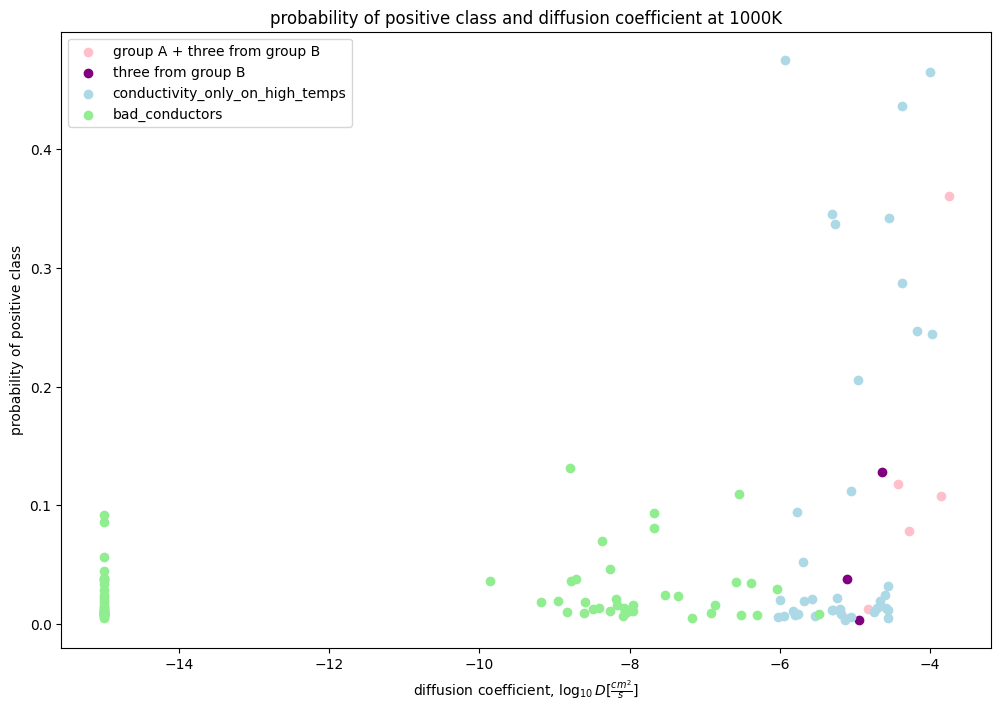

In [138]:
plt.figure(figsize=(12, 8))

first_group = df[df['multigroup'] == 'group A']
second_group = df[df['multigroup'] == 'three from group B']
third_group = df[df['multigroup'] == 'conductivity_only_on_high_temps']
fourth_group = df[df['multigroup'] == 'bad_conductors']

plt.scatter(np.log10(first_group['diffusion_coef']), first_group['preds'].to_list(), label='group A + three from group B', c = 'pink')
plt.scatter(np.log10(second_group['diffusion_coef']), second_group['preds'].to_list(), label='three from group B', c = 'purple')
plt.scatter(np.log10(third_group['diffusion_coef']).to_list(), third_group['preds'].to_list(), label='conductivity_only_on_high_temps', c = 'lightblue')
plt.scatter(np.log10(fourth_group['diffusion_coef']).to_list(), fourth_group['preds'].to_list(), label='bad_conductors', c = 'lightgreen')

plt.xlabel('diffusion coefficient, $\log_{10}D[\\frac{cm^2}{s}]$')
plt.ylabel('probability of positive class')

plt.title('probability of positive class and diffusion coefficient at 1000K')

plt.legend();

In [139]:
classes = np.loadtxt('multiclassification_results/classes.txt', dtype=str, delimiter=' ')
preds = np.loadtxt('multiclassification_results/preds.txt', dtype=float, delimiter=' ')

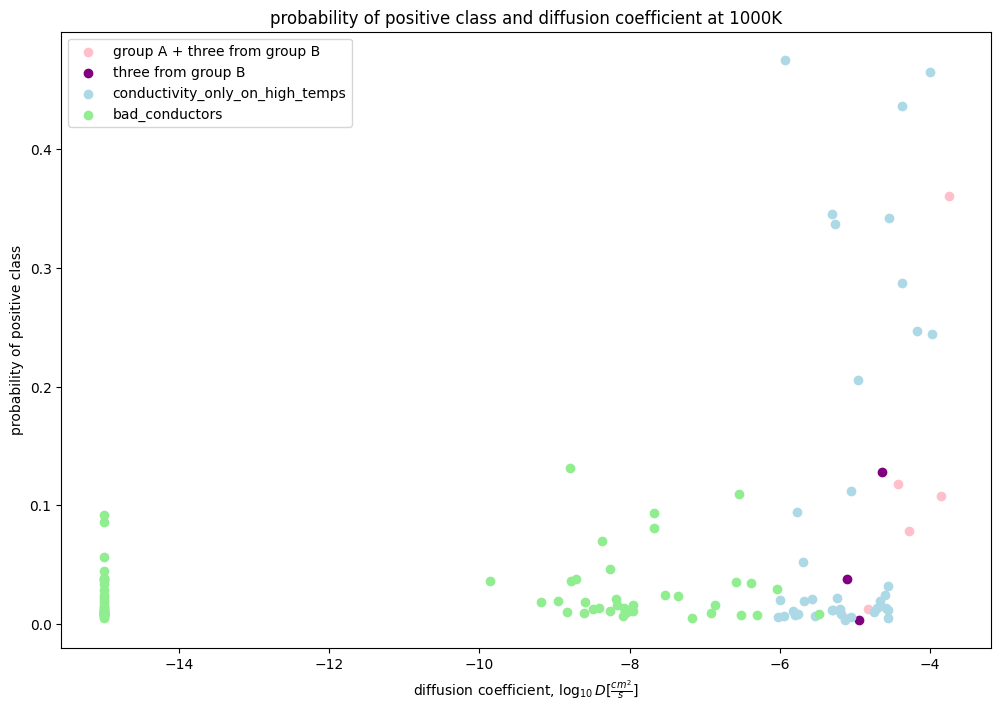

In [140]:
plt.figure(figsize=(12, 8))

first_group = df[df['multigroup'] == 'group A']
second_group = df[df['multigroup'] == 'three from group B']
third_group = df[df['multigroup'] == 'conductivity_only_on_high_temps']
fourth_group = df[df['multigroup'] == 'bad_conductors']

plt.scatter(np.log10(first_group['diffusion_coef']), first_group['preds'].to_list(), label='group A + three from group B', c = 'pink')
plt.scatter(np.log10(second_group['diffusion_coef']), second_group['preds'].to_list(), label='three from group B', c = 'purple')
plt.scatter(np.log10(third_group['diffusion_coef']).to_list(), third_group['preds'].to_list(), label='conductivity_only_on_high_temps', c = 'lightblue')
plt.scatter(np.log10(fourth_group['diffusion_coef']).to_list(), fourth_group['preds'].to_list(), label='bad_conductors', c = 'lightgreen')

plt.xlabel('diffusion coefficient, $\log_{10}D[\\frac{cm^2}{s}]$')
plt.ylabel('probability of positive class')

plt.title('probability of positive class and diffusion coefficient at 1000K')

plt.legend();

In [152]:
classes = np.loadtxt('multiclassification_results/classes.txt', dtype=str, delimiter=' ')
preds = np.loadtxt('multiclassification_results/preds.txt', dtype=float, delimiter=' ')

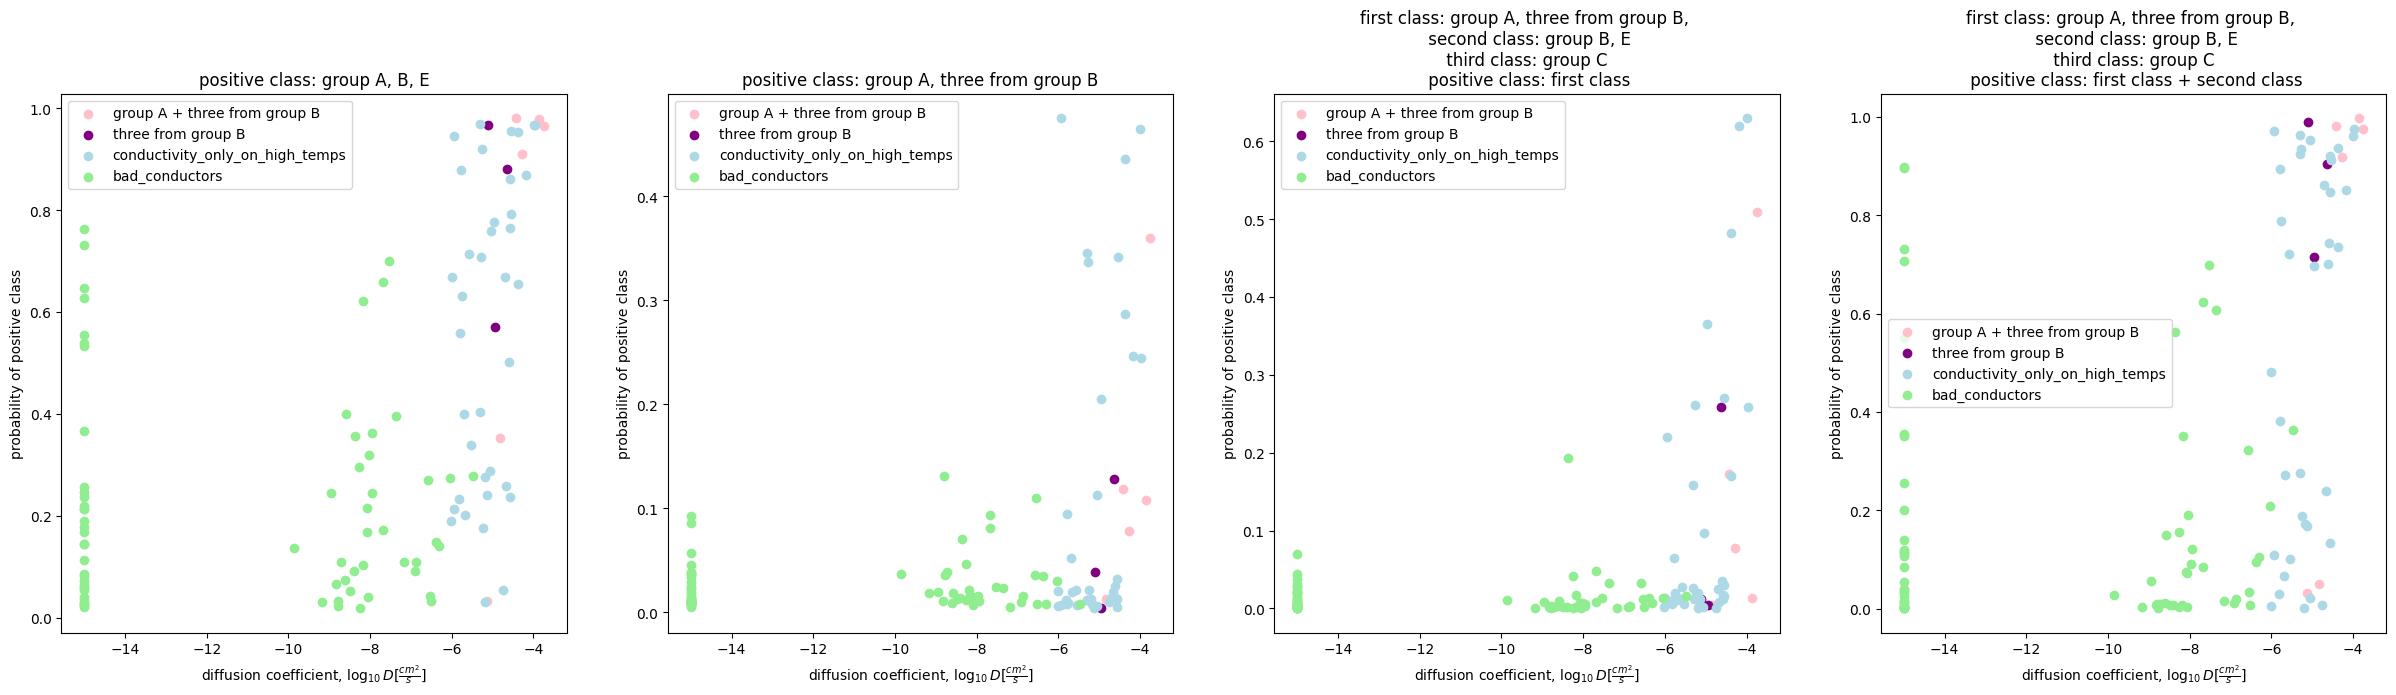

In [168]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 7))


pathes = ['binaryclassification_results/preds.txt', 'binaryclassification_results_new_labels/preds.txt', 'multiclassification_results/preds.txt', 'multiclassification_results/preds.txt']
titles = ['positive class: group A, B, E', 'positive class: group A, three from group B', 'first class: group A, three from group B, \n second class: group B, E\n third class: group C \n positive class: first class', 'first class: group A, three from group B, \n second class: group B, E\n third class: group C \n positive class: first class + second class']

for i, path in enumerate(pathes):
    preds = np.loadtxt(path, dtype=float, delimiter=' ')
    if i == 2:
        df['preds'] = preds[:, 2]
    elif i == 3:
        df['preds'] = preds[:, 1] + preds[:, 2]
    else:
        df['preds'] = preds[:, 1]
    first_group = df[df['multigroup'] == 'group A']
    second_group = df[df['multigroup'] == 'three from group B']
    third_group = df[df['multigroup'] == 'conductivity_only_on_high_temps']
    fourth_group = df[df['multigroup'] == 'bad_conductors']

    axs[i].scatter(np.log10(first_group['diffusion_coef']), first_group['preds'].to_list(), label='group A + three from group B', c = 'pink')
    axs[i].scatter(np.log10(second_group['diffusion_coef']), second_group['preds'].to_list(), label='three from group B', c = 'purple')
    axs[i].scatter(np.log10(third_group['diffusion_coef']).to_list(), third_group['preds'].to_list(), label='conductivity_only_on_high_temps', c = 'lightblue')
    axs[i].scatter(np.log10(fourth_group['diffusion_coef']).to_list(), fourth_group['preds'].to_list(), label='bad_conductors', c = 'lightgreen')

    axs[i].set_xlabel('diffusion coefficient, $\log_{10}D[\\frac{cm^2}{s}]$')
    axs[i].set_ylabel('probability of positive class')

    axs[i].set_title(titles[i])

    axs[i].legend();

